# Quantinuum error with system size

This note book explores the relationship between the error in energy expectation $\Delta\lang H\rang$ of a hamiltonian and the size of the system $L$.

For this purpose, we only consider the energy of the original hamiltonian without applying VQE. We obtain the error by comparing the simulation results with the theoretical calculation.

The following are the hamiltonian models we consider:
$$
H_{TLFIM} = - \sum _{i=0}^N \left ( Z_i Z_{i + 1} + h_0 X_i + h_1 Z_i \right ).
$$


## Noiseless
In the noiseless case, for TLFIM, without VQE, the measurement circuit for the $Z$ Pauli operators is empty, and thus the expectation shall not have any error. The error will only come from the terms $h_0\sum X_i$.

This is obtained from applying a Hadamard gate to each qubit. Therefore, we will be measuring the (potentially additive?) error of the Hadamard gate.

Let us measure $\lang Z\rang$ with a hadamard gate applied to each qubit. This is equivalent to measuring $\lang X\rang$.

In [5]:
from datetime import datetime

from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter
from pytket.utils.operators import QubitPauliOperator
from pytket.partition import measurement_reduction, MeasurementBitMap, MeasurementSetup, PauliPartitionStrat
from pytket.backends.backendresult import BackendResult
from pytket.pauli import Pauli, QubitPauliString
from pytket.circuit import Qubit

from scipy.optimize import minimize
from numpy import ndarray
from numpy.random import random_sample
from sympy import Symbol
from functools import partial

import qnexus as qnx
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

In [2]:
qnx.client.auth.login_with_credentials()

✅ Successfully logged in as xiaoyue.li@ntu.edu.sg.


In [3]:
# Connect to project
project_ref = qnx.projects.get_or_create(name="CLT_tests")
project_ref.df()

# set this in the context
qnx.context.set_active_project(project_ref)

In [4]:
# helper functions
def create_qubit_pauli_string(nqubits, specify_ls, coef):
    '''
    specify_ls: {index:Pauli.X/Y/Z}
    '''
    term = {}
    specified_ids = list(specify_ls.keys())
    for i in range(nqubits):
        if i in specified_ids:
            term.update({Qubit(i):specify_ls[i]})
        else:
            term.update({Qubit(i):Pauli.I})

    return {QubitPauliString(term):coef}

To measure the error of $\sum_{i=0}^L\lang X_i\rang$, we will first run the test for system size 1-20.

Our theoretical prediction is that $\sum_{i=0}^L\lang X_i\rang = 0$. Intuitively,
we can understand as the Hadamard gate rotates each $|0\rang$ into the eigenstates of $X$ with equal probability, then the expected energy (eigenvalue) will be canceled out. 

In [15]:
nshots = 500
sys_sizes = [int(i) for i in np.linspace(1,20,11)]
circuit_list = []
for nqubits in sys_sizes:
    circuit = Circuit(nqubits)
    for i in range(nqubits):
        circuit.H(i)
    circuit.measure_all()
    circuit_ref = qnx.circuits.upload(
        name=f"system_size_test {nqubits}",
        circuit = circuit,
        project = project_ref,
    )
    circuit_list.append(circuit_ref)

In [27]:
ham_list = []
for nqubits in sys_sizes:
    terms = {}
    for i in range(nqubits):
        # term_x_i = create_qubit_pauli_string(nqubits, {i: Pauli.Z, (i+1)%nqubits: Pauli.Z}, -1)
        term_z_i = create_qubit_pauli_string(nqubits, {i: Pauli.Z}, 1)
        # terms.update(term_x_i)
        terms.update(term_z_i)
    ham_list.append(QubitPauliOperator(terms))

In [16]:
# Compile and fetch the circuit
compiled_circuits = qnx.compile(
    circuits=circuit_list,
    name=f"system_size_test_noiseless",
    optimisation_level=1,
    backend_config=qnx.QuantinuumConfig(device_name="H1-1LE"),
    project=project_ref,
)

compiled_circuits.df()

,name,description,created,modified,project,id
0,system_size_test 1-QuantinuumBackend-final,None,2024-10-15 14:24:15.009734+00:00,2024-10-15 14:24:15.009734+00:00,CLT_tests,85efefcb-8143-4551-b0c5-f2cce4f923cf
1,system_size_test 2-QuantinuumBackend-final,None,2024-10-15 14:24:15.588026+00:00,2024-10-15 14:24:15.588026+00:00,CLT_tests,66f08617-7a27-4b67-acd1-566cc491faaf
2,system_size_test 4-QuantinuumBackend-final,None,2024-10-15 14:24:15.800693+00:00,2024-10-15 14:24:15.800693+00:00,CLT_tests,9b259994-dcce-4948-8a3e-ac0cfe6a6cd9
3,system_size_test 6-QuantinuumBackend-final,None,2024-10-15 14:24:16.623925+00:00,2024-10-15 14:24:16.623925+00:00,CLT_tests,ee340264-2fe4-4973-8e40-dd6a18419175
4,system_size_test 8-QuantinuumBackend-final,None,2024-10-15 14:24:16.848372+00:00,2024-10-15 14:24:16.848372+00:00,CLT_tests,8b82f0da-a675-40bd-a54b-a2258169c3d9
5,system_size_test 10-QuantinuumBackend-final,None,2024-10-15 14:24:17.280724+00:00,2024-10-15 14:24:17.280724+00:00,CLT_tests,443b7b49-8b31-432b-84ca-6d7e9ec6fd9d
6,system_size_test 12-QuantinuumBackend-final,None,2024-10-15 14:24:17.802653+00:00,2024-10-15 14:24:17.802653+00:00,CLT_tests,ff8d0e01-0da7-4d89-a1b4-7b3ec3fc9a04
7,system_size_test 14-QuantinuumBackend-final,None,2024-10-15 14:24:18.342865+00:00,2024-10-15 14:24:18.342865+00:00,CLT_tests,bc07f1f0-9d58-414d-beb2-ab14f7bcc7b9
8,system_size_test 16-QuantinuumBackend-final,None,2024-10-15 14:24:18.835881+00:00,2024-10-15 14:24:18.835881+00:00,CLT_tests,0287050d-828b-4aaa-b3ae-70c61dbdee02
9,system_size_test 18-QuantinuumBackend-final,None,2024-10-15 14:24:19.402565+00:00,2024-10-15 14:24:19.402565+00:00,CLT_tests,b945f148-83d7-42d3-ab32-e40112ac4364


In [17]:
# Execute circuit on simulator
execute_job_ref = qnx.start_execute_job(
    circuits=compiled_circuits,
    name=f"execute_system_size_noiseless_1",
    n_shots=[nshots]* len(compiled_circuits),
    backend_config=qnx.QuantinuumConfig(device_name="H1-1LE"),
    project=project_ref,
)

execute_job_ref.df()

,name,description,created,modified,job_type,last_status,project,id
0,execute_system_size_noiseless_1,,2024-10-15 14:25:26.203901+00:00,2024-10-15 14:25:26.203901+00:00,JobType.EXECUTE,StatusEnum.SUBMITTED,CLT_tests,0e03b422-889d-4d44-b67b-6c2b12f34ce7


In [21]:
print(qnx.jobs.status(execute_job_ref))

# Block until the job is complete
qnx.jobs.wait_for(execute_job_ref)

# Retrieve a ExecutionResultRef for every Circuit that was executed
execute_job_result_refs = qnx.jobs.results(execute_job_ref)

# Get a pytket BackendResult for the execution
result = execute_job_result_refs[0].download_result()

result.get_counts()

JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2024, 10, 15, 14, 28, 51, 4298, tzinfo=datetime.timezone.utc), queued_time=None, submitted_time=datetime.datetime(2024, 10, 15, 14, 25, 26, 208048, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2024, 10, 15, 14, 28, 17, 226694, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=None)


Counter({(0,): 234, (1,): 266})

In [37]:
expect_ls = []
for i in range(len(sys_sizes)):
    result = execute_job_result_refs[i].download_result()
    distribution = result.get_distribution()
    expect = 0
    for key, value in distribution.items():
        new_key = [-(j*2-1) for j in key]
        expect += sum(new_key) * value
    expect_ls.append(expect)
    

In [41]:
print(expect_ls)

[-0.064, -0.06, 0.03599999999999995, -0.051999999999999824, 0.18800000000000008, 0.06799999999999996, -0.13599999999999995, -0.13599999999999995, 0.008000000000000004, 0.5360000000000003, 0.2199999999999999]


Text(0, 0.5, 'Expected energy')

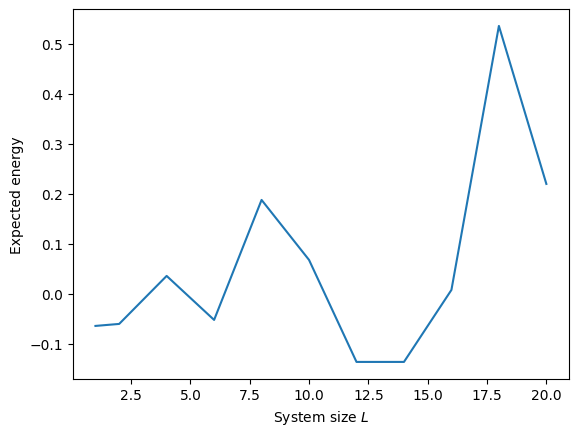

In [42]:
plt.plot(sys_sizes, expect_ls)
plt.xlabel(r'System size $L$')
plt.ylabel(r'Expected energy')

Here, we can see a general trend of the error growing with system size $L$.
However, to obtain a more definite trend, we need to run this experiment multiple times.

In [43]:
# modify previous result list
# expect_ls = [[expect] for expect in expect_ls]
# print(expect_ls)

[[-0.064], [-0.06], [0.03599999999999995], [-0.051999999999999824], [0.18800000000000008], [0.06799999999999996], [-0.13599999999999995], [-0.13599999999999995], [0.008000000000000004], [0.5360000000000003], [0.2199999999999999]]


In [44]:
rounds = 20
for round in range(rounds):
    execute_job_ref = qnx.start_execute_job(
    circuits=compiled_circuits,
    name=f"execute_system_size_noiseless_round{round}",
    n_shots=[nshots]* len(compiled_circuits),
    backend_config=qnx.QuantinuumConfig(device_name="H1-1LE"),
    project=project_ref,
    )
    print(qnx.jobs.status(execute_job_ref))
    # Block until the job is complete
    qnx.jobs.wait_for(execute_job_ref)
    # Retrieve a ExecutionResultRef for every Circuit that was executed
    execute_job_result_refs = qnx.jobs.results(execute_job_ref)
    # Get a pytket BackendResult for the execution
    for i,nqubits in enumerate(sys_sizes):
        result = execute_job_result_refs[i].download_result()
        distribution = result.get_distribution()
        expect = 0
        for key, value in distribution.items():
            new_key = [-(j*2-1) for j in key]
            expect += sum(new_key) * value
        expect_ls[i].append(expect)

JobStatus(status=<StatusEnum.SUBMITTED: 'Circuit has been submitted.'>, message='Job has been submitted to Nexus.', error_detail=None, completed_time=None, queued_time=None, submitted_time=datetime.datetime(2024, 10, 16, 3, 32, 30, 472599, tzinfo=datetime.timezone.utc), running_time=None, cancelled_time=None, error_time=None, queue_position=None)
JobStatus(status=<StatusEnum.SUBMITTED: 'Circuit has been submitted.'>, message='Job has been submitted to Nexus.', error_detail=None, completed_time=None, queued_time=None, submitted_time=datetime.datetime(2024, 10, 16, 3, 35, 54, 399409, tzinfo=datetime.timezone.utc), running_time=None, cancelled_time=None, error_time=None, queue_position=None)
JobStatus(status=<StatusEnum.SUBMITTED: 'Circuit has been submitted.'>, message='Job has been submitted to Nexus.', error_detail=None, completed_time=None, queued_time=None, submitted_time=datetime.datetime(2024, 10, 16, 3, 36, 32, 635246, tzinfo=datetime.timezone.utc), running_time=None, cancelled_ti

In [46]:
expect_ls

[[-0.064,
  0.0040000000000000036,
  -0.0040000000000000036,
  0.040000000000000036,
  -0.064,
  -0.020000000000000018,
  -0.03600000000000003,
  -0.016000000000000014,
  -0.020000000000000018,
  0.008000000000000007,
  -0.008000000000000007,
  0.06000000000000005,
  -0.03200000000000003,
  0.01200000000000001,
  0.04800000000000004,
  -0.008000000000000007,
  0.05600000000000005,
  -0.008000000000000007,
  0.0,
  -0.052000000000000046,
  -0.11200000000000004],
 [-0.06,
  0.11599999999999999,
  0.09599999999999992,
  0.02400000000000002,
  0.055999999999999994,
  0.15199999999999997,
  0.01200000000000001,
  -0.01200000000000001,
  0.06800000000000006,
  0.03600000000000003,
  -0.07200000000000001,
  -0.12,
  -0.10400000000000004,
  0.16799999999999998,
  -0.020000000000000018,
  0.03600000000000003,
  0.12000000000000005,
  -0.064,
  -0.08000000000000002,
  -0.06,
  0.13200000000000006],
 [0.03599999999999995,
  -0.0040000000000000036,
  0.03200000000000003,
  -0.003999999999999948,
 

In [48]:
mean_ls = [abs(np.mean(expect)) for expect in expect_ls]
std_ls = [np.std(expect) for expect in expect_ls]

Text(0, 0.5, 'Expected energy')

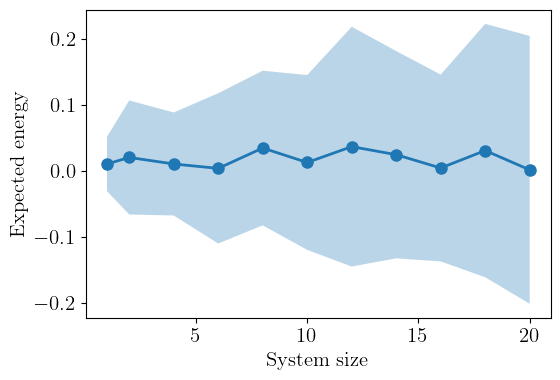

In [74]:
fig, ax = plt.subplots(figsize=(6, 4))
mean_ls = np.asarray(mean_ls)
std_ls = np.asarray(std_ls)
ax.plot(sys_sizes, mean_ls, 'o-', label='Mean')
ax.fill_between(sys_sizes, mean_ls - std_ls, mean_ls + std_ls, alpha=0.3)
ax.set_xlabel('System size')
ax.set_ylabel('Expected energy')

In [55]:
def run_param_rc(fontsize = 15):
        import matplotlib.pyplot as plt
        plt.rcParams['axes.labelsize'] = fontsize
        plt.rcParams['axes.titlesize'] = fontsize
        plt.rcParams['font.size'] = fontsize
        #set_matplotlib_formats('pdf', 'png')
        plt.rcParams['savefig.dpi'] = 75
        plt.rcParams['lines.linewidth'] = 2.0
        plt.rcParams['lines.markersize'] = 8
        plt.rcParams['legend.fontsize'] = 12
        plt.rcParams['legend.labelspacing'] = .3
        plt.rcParams['legend.columnspacing']= .3
        plt.rcParams['legend.handletextpad']= .1
        plt.rcParams['text.usetex'] = True
        plt.rcParams['mathtext.fontset'] = 'stix'
        plt.rcParams['font.family'] = 'STIXGeneral'
        plt.rcParams['font.serif'] = "cm"
run_param_rc()
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.optimize import curve_fit
def fit_over_sqrt(i, c):
    return c * i ** (0.5)

# Perform a curve fit on the data
params, covariance = curve_fit(fit_over_sqrt, np.array(sys_sizes), np.array(std_ls))

# Extract the fitted parameters
fitted_c = params

# Generate the fitted curve
fitted_y_vals = fit_over_sqrt(np.array(sys_sizes), np.array(fitted_c))
print(fitted_c)

[0.0437586]


/var/folders/sn/4ym_qb8x0cs_f961d78kvvkc0000gn/T/ipykernel_43251/2329750149.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


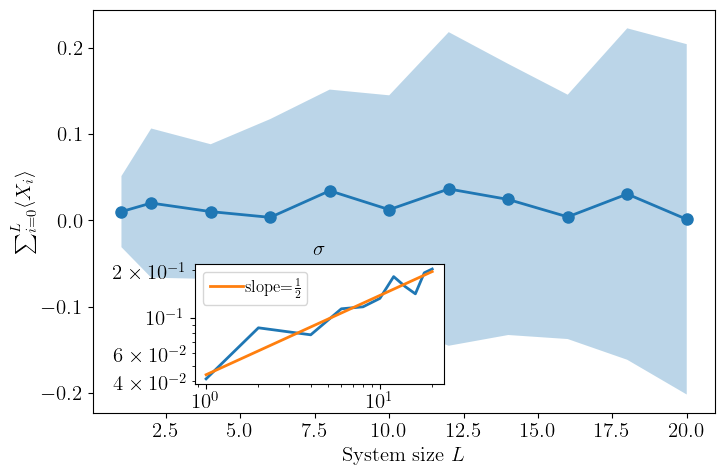

In [79]:
fig, ax = plt.subplots(figsize=(3*2.5, 2*2.5))
mean_ls = np.asarray(mean_ls)
std_ls = np.asarray(std_ls)
ax.plot(sys_sizes, mean_ls, 'o-', label='Mean')
ax.fill_between(sys_sizes, mean_ls - std_ls, mean_ls + std_ls, alpha=0.3)
ax.set_xlabel(r'System size $L$')
ax.set_ylabel(r'$\sum_{i=0}^{L}\langle X_i\rangle$')
inset_ax = inset_axes(ax, width="40%", height="30%", loc='lower left', 
                      bbox_to_anchor=(0.15, 0.05, 1, 1),  # Adjust the values to move the inset
                      bbox_transform=ax.transAxes) 
inset_ax.plot(sys_sizes, std_ls)
inset_ax.plot(sys_sizes, [fitted_c * shot ** (0.5) for shot in sys_sizes], label=r'slope=$\frac{1}{2}$')
inset_ax.set_yscale('log')
inset_ax.set_xscale('log')
inset_ax.set_title(r'$\sigma$')
inset_ax.legend()
fig.tight_layout()
fig.savefig('clt2.pdf')


# With noise